# Goal: To create a dataset is big enough to be able to provide sufficient data for a transformer based NLP model.
## This was achieved by combining 3 smaller datasets into one big dataset.

### Datasets' sources:
1. https://www.kaggle.com/datasets/simaanjali/emotion-analysis-based-on-text
2. https://www.kaggle.com/datasets/divu2001/text-with-sentiment
3. https://www.kaggle.com/datasets/pashupatigupta/emotion-detection-from-text

# Importing datasets and libraries

In [4]:
import pandas as pd
import os
import re
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
ds1=pd.read_csv(r"C:\Users\13400f_RTX4060ti\Desktop\datasets\emotion_sentimenT_dataset.csv")
ds2=pd.read_csv(r"C:\Users\13400f_RTX4060ti\Desktop\datasets\emotion_dataset_raw.csv")
ds3=pd.read_csv(r"C:\Users\13400f_RTX4060ti\Desktop\datasets\tweet_emotions.csv")
print(ds1.shape)
print(ds2.shape)
print(ds3.shape)

(839555, 3)
(34792, 2)
(40000, 3)


# Data Cleaning

### Changing column names to a standard name

In [5]:
ds1.rename(columns={'Emotion':'emotion'},inplace=True)
ds2.rename(columns={'Emotion':'emotion'},inplace=True)
ds3.rename(columns={'sentiment':'emotion'},inplace=True)
ds2.rename(columns={'Text':'text'},inplace=True)
ds3.rename(columns={'content':'text'},inplace=True)
print(ds1.columns)
print(ds2.columns)
print(ds3.columns)

ds1_save=ds1.copy()
ds2_save=ds2.copy()
ds3_save=ds3.copy()

Index(['Unnamed: 0', 'text', 'emotion'], dtype='object')
Index(['emotion', 'text'], dtype='object')
Index(['tweet_id', 'emotion', 'text'], dtype='object')


### Dropping unnecessary columns

In [6]:
first_column_name = ds1.columns[0]
ds1.drop(columns=[first_column_name],inplace=True)
ds3.drop(columns=['tweet_id'],inplace=True)
print(ds1.columns)
print(ds2.columns)
print(ds3.columns)

Index(['text', 'emotion'], dtype='object')
Index(['emotion', 'text'], dtype='object')
Index(['emotion', 'text'], dtype='object')


### Altering shape of the dataframes into a standard shape

In [7]:
new_order=['text','emotion']
ds2=ds2[new_order]
ds3=ds3[new_order]
print(ds1.columns)
print(ds2.columns)
print(ds3.columns)

Index(['text', 'emotion'], dtype='object')
Index(['text', 'emotion'], dtype='object')
Index(['text', 'emotion'], dtype='object')


# Feature Engineering

### Removing usernames and URLs

In [14]:
def remove_usernames(text):
    cleaned_text = re.sub(r'@\w+', '', text) #Regex to replace usernames with one whitespace
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip() #Regex to replace one or more CONTINOUS whitespace with one whitepace and .strip() remove leading an trailing whitespace
    return cleaned_text

def remove_urls(text):
    url_pattern = r'https?://\S+|www\.\S+|\S+\.\w{2,3}(/\S*)?' #Complicated regex, I do not understand anything in this
    cleaned_text = re.sub(url_pattern, '', text, flags=re.IGNORECASE)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text

datasets=[ds1,ds2,ds3]
for dataset in datasets:
    dataset['text'] = dataset['text'].apply(remove_usernames)
    dataset['text'] = dataset['text'].apply(remove_urls)
print("Process done.")

Process done.


### Removing just the hashtag symbol but keeping the words from a hashtag

In [9]:
def remove_hashtag_symbol(text):
    cleaned_text = re.sub(r'#(\w+)', r'\1', text) #Complicated regex, I do not understand anything in this. The key point is that it only removes the '#' symbol from a given hashtag and keeps the rest of the words.
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text
for dataset in datasets:
    dataset['text'] = dataset['text'].apply(remove_hashtag_symbol)

print("Process done.")

Process done.


### Mapping similar emotions into one emotion in the smaller datasets
I opted to map "joy" into "happiness" as they are basically the same thing

In [10]:
ds2['emotion']=ds2['emotion'].replace('joy','happiness')


In [11]:
print("Columns in ds1:", ds1.columns)
print("Shape of ds1:", ds1.shape)
print("-" * 60)
print("Columns in ds2:", ds2.columns)
print("Shape of ds2:", ds2.shape)
print("-" * 60)
print("Columns in ds3:", ds3.columns)
print("Shape of ds3:", ds3.shape)

Columns in ds1: Index(['text', 'emotion'], dtype='object')
Shape of ds1: (839555, 2)
------------------------------------------------------------
Columns in ds2: Index(['text', 'emotion'], dtype='object')
Shape of ds2: (34792, 2)
------------------------------------------------------------
Columns in ds3: Index(['text', 'emotion'], dtype='object')
Shape of ds3: (40000, 2)


### Merging the 3 datasets into one dataset

In [12]:
ds_i=pd.concat([ds1,ds2,ds3],ignore_index=True)
print(ds_i.columns)
ds_i.head()

Index(['text', 'emotion'], dtype='object')


,text,emotion
0,i seriously hate one subject to death but now ...,hate
1,im so full of life i feel appalled,neutral
2,i sit here to write i start to dig out my feel...,neutral
3,ive been really angry with r and i feel like a...,anger
4,i feel suspicious if there is no one outside l...,neutral


In [15]:
output_path=r'./final_dataset.csv'
ds_i.to_csv(output_path,index=False) #index=False ensures that the index column isnt included in the CSV file, so for this exmaple the CSV will only have |text|emotion|

#### Visualization

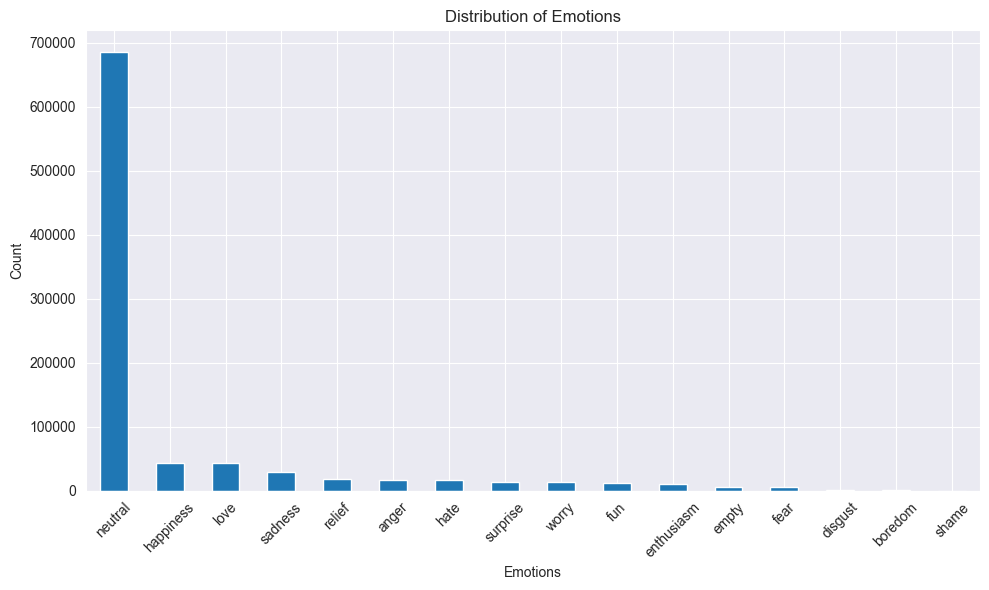

In [16]:
emotion_counts=ds_i['emotion'].value_counts()
emotion_counts.plot(kind="bar",figsize=(10,6))
plt.xlabel("Emotions")
plt.ylabel("Count")
plt.title("Distribution of Emotions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Dropping insginificant emotions

In [17]:
emotions_to_drop=['boredom','shame','disgust']
ds_i=ds_i[~ds_i['emotion'].isin(emotions_to_drop)].reset_index(drop=True)#Creating a boolean array wrt to the emotions in emotions_to_drop. Negating the created boolean array and sending this new one to the dataframe
print(ds_i['emotion'].value_counts())
print(f"Length: {len(ds_i['emotion'])}")

emotion
neutral       685430
happiness      43429
love           43395
sadness        29368
relief         18255
anger          16743
hate           16590
surprise       13203
worry          12934
fun            11851
enthusiasm     10063
empty           6369
fear            5410
Name: count, dtype: int64
Length: 913040


### Merging similar emotions together in the pooled dataset (ds_i)
I again opted to merge "worry" and "fear" into "sadness". In hindsight I probably wouldn't do this again

In [18]:
ds_i['emotion']=ds_i['emotion'].replace('worry','sadness')
ds_i['emotion']=ds_i['emotion'].replace('fear','sadness')

### Downsampling
Since the dataset is highly imbalanced, I select 10k documents from each option randomly and discard the rest.

In [19]:
max_sample_size=10000
def downsample(df,target_col,max):
  ds=ds_i.groupby(target_col).apply(lambda x:x.sample(n=min(len(x),max))).reset_index(drop=True) #apply loops though all the unique emotions' dataframes and assigns it to x
  return ds
ds_i=downsample(ds_i,'emotion',max_sample_size)
print(ds_i['emotion'].value_counts())
print(f"Length: {len(ds_i['emotion'])}")

emotion
anger         10000
enthusiasm    10000
fun           10000
neutral       10000
happiness     10000
hate          10000
love          10000
sadness       10000
relief        10000
surprise      10000
empty          6369
Name: count, dtype: int64
Length: 106369


C:\Users\13400f_RTX4060ti\AppData\Local\Temp\ipykernel_3980\548560940.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ds=ds_i.groupby(target_col).apply(lambda x:x.sample(n=min(len(x),max))).reset_index(drop=True) #apply loops though all the unique emotions' dataframes and assigns it to x


### Creating a homogenous dataset
Here I randomly shuffle the newly formed datasets so that the different emotions are distributed evenly in a homogenous manner.

In [20]:
ds=ds_i.sample(frac=1.0,random_state=1).reset_index(drop=True)#frac=1.0 means that .sample selects 100% of the dataframe. reset_index(drop=True) drops old indices and creates new ones
print(ds.head())
print("-"*75)
print(ds.tail())
output_path=r'./final_dataset.csv'
ds.to_csv(output_path,index=False)

                                                text     emotion
0  i feel rather funny ending with so many dupes ...         fun
1                     i feel surprised by the result    surprise
2                    i am officially feeling festive     neutral
3  i suddenly found myself standing before this w...    surprise
4  i look at the meager pile of food i purchased ...  enthusiasm
---------------------------------------------------------------------------
                                                     text   emotion
106364  i used to feel strongly about how much i hated...      hate
106365  i feel like i just got a spirit booster this r...  surprise
106366  i could come up with is that i was really feel...     anger
106367  i find it really it helps to have an outfit of...    relief
106368  i can t help feeling surprised by his sudden call  surprise
